# Challenge 1 - Getting started <img align="right" src="../Supplementary_data/EY_logo.png" style="margin:0px 50px">

Welcome to the 2020 NextWave Data Science Challenge!  Thank you for taking part in the private challenge and helping us test and improve the student experience.

We have prepared a small initial dataset for you to start flexing your data science muscles. We are hoping you will be able to open and view some data, create a basic solution to the problem, and submit your results via the EY Data Science platform.

## Registering for the challenge and getting the data

Prior to running this notebook, make sure you have:
* **Created a profile** on the [EY Data Science Platform](http://datascience.cognistreamer.com/)
* **Registered** for the "NextWave Bushfire Challenge Phase 1 - Detect fire edges in airborne image" on the Platform
* **Downloaded and extracted** the "myPrivateChallenge1.zip" file under "Additional data" from the Challenge page on the Platform
* **Uploaded** the contents of the .zip file into your jupyter environment, in the "03_Data_science_challenge" folder.

Your folder structure should look like the below:

<img src="../Supplementary_data/EY_Challenge1_Getting_started/folder_structure.png">

To check you have executed this correct, execute the code cell below and compare the contents of your current working directory (where this notebook is executing from) to the image above. You should see:

* `/home/jovyan/03_Data_science_challenge` showing you are working in the "03_Data_science_challenge" folder.

* `['.ipynb_checkpoints', 'EY_Challenge1_Getting_started.ipynb', 'input_linescan', 'test.csv', 'tgt_mask', 'train.csv', 'world']` showing the contents of the folder.

In [5]:
import os
print(os.getcwd())
print(os.listdir())

/home/jovyan/03_Data_science_challenge
['.ipynb_checkpoints', 'EY_Challenge1_Getting_started.ipynb', 'input_linescan', 'test.csv', 'tgt_mask', 'train.csv', 'world']


## A quick word on the data

The initial dataset is organised into the following folder structure:
<ul>
    <li><b>input_linescan</b>: these are images of fires taken from a plane. They are simple .jpg files, not georeferenced in space.</li>
    <li><b>tgt_mask</b>: these are masks which align to the linescan images. They have been manually drawn based on the linescan images.</li>
    <li><b>world</b>: these are strings of numbers called "world" files used for georeferencing the linescan and mask files. They put the .jpg files 'in context' with respect to a Coordinate Reference System (CRS).</li>
    </ul>
    
There are 25 linescan and associated world images, however only 20 masks. Your task is to use the 20 linescan/mask pairs to train a model or process which can produce a mask for the remaining 5 linescans with no mask. 

In [51]:
%matplotlib inline
import os
import numpy as np
import pandas as pd

import datacube
import rasterio
import matplotlib.pyplot as plt

from skimage import io
from skimage import data
from skimage import color
from skimage import morphology
from skimage import segmentation
from skimage import measure

from affine import Affine
from rasterio.plot import show, show_hist

### Import input variable: aerial linescan images

In [13]:
file_stem = 'JORDAN 244 P1_201901291522_MGA94_55'
raster_filename = 'input_linescan/' + file_stem + '.jpg'
world_filename = 'world/'  + file_stem + '.bqw'

In [14]:
src = rasterio.open(raster_filename, mode='r+')
src.read()

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)

 ### Contextualise raster data in space by providing a Coordinate Reference System (CRS) and transform function

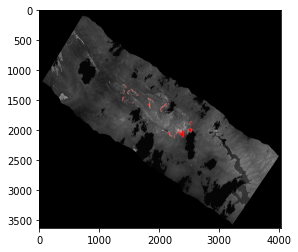

In [15]:
show(src.read())

Note that this raster data is just a table of values, it is not pinned to a particular location, or "georeferenced". For this we need a CRS and an affine transformation function.

1. CRS: 'epsg:28355' is a useful CRS for Australia, otherwise known as GDA94 / MGA zone 55. https://epsg.io/28355
2. Affine transformation function: we also need a transformation function to descibe the how to transform our raster data into the relevant CRS. This includes the location, scale and rotation of our raster data. These values can be found in the world files ending in '.bqw' files of the same name. https://en.wikipedia.org/wiki/World_file

In [16]:
a, d, b, e, c, f = np.loadtxt(world_filename)    # order depends on convention
transform = Affine(a, b, c, d, e, f)
crs = rasterio.crs.CRS({"init": "epsg:28355"})     # "epsg:4326"  WGS 84,  or whatever CRS you know the image is in

src.transform = transform
src.crs = crs

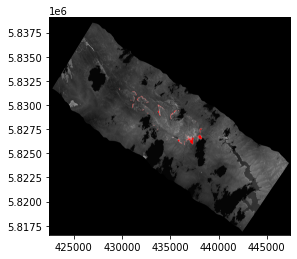

In [17]:
show(src.read(), transform=src.transform)

Note that the coordinates of the image are now shown in the 'epsg:28355' CRS. This means our data is no longer just an image, but an observation of a particular location.

### Compare against the target mask
Each linescan/mask pair share the same transform (found in the world file of the same name), so we can reuse the transform defined above to view the target for this particular linescan.

In [18]:
mask_filename = 'tgt_mask/' + file_stem + '.jpg'

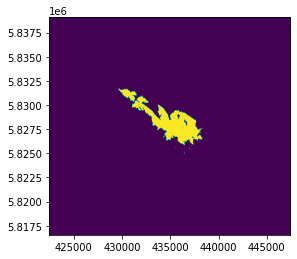

In [19]:
tgt = rasterio.open(mask_filename, mode='r+')

tgt.transform = transform
tgt.crs = crs

show(tgt.read(), transform=tgt.transform)

Plotting the linescan and the mask together allows us to take a look at how they compare.

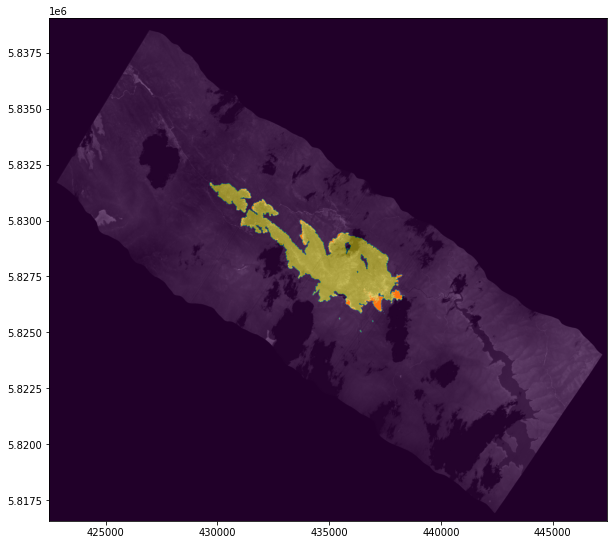

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

show(src.read(), transform=src.transform, ax=ax)
show(tgt.read(), transform=src.transform, ax=ax, alpha=0.5)

### Understanding the linescan files

In [21]:
src.read().shape

(3, 3629, 4025)

We can see that there are three channgels in the raster image file: red, green and blue. If we show these individually we can see the image is similar for all three channels

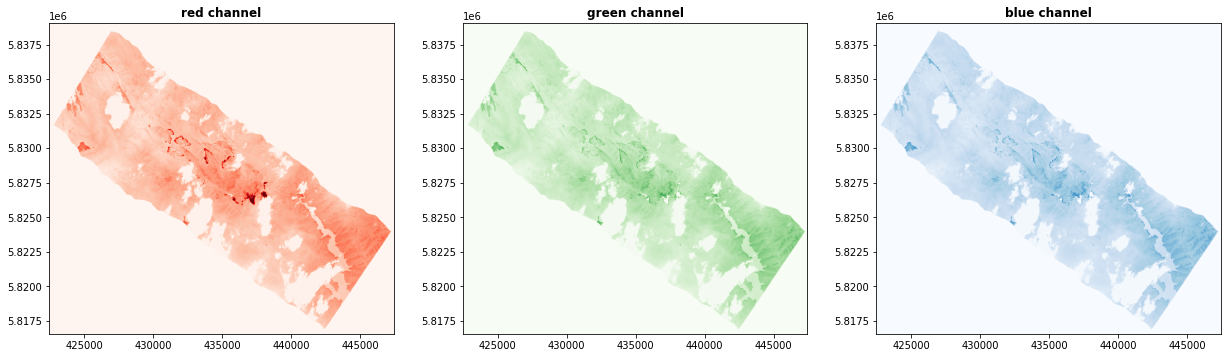

In [22]:
r = src.read(1)
g = src.read(2)
b = src.read(3)

fig, (axr, axg, axb) = plt.subplots(1,3, figsize=(21,7))
show(r, ax=axr, cmap='Reds', title='red channel', transform=src.transform)
show(g, ax=axg, cmap='Greens', title='green channel', transform=src.transform)
show(b, ax=axb, cmap='Blues', title='blue channel', transform=src.transform)
plt.show()

A histogram of each channel shows that the distribution of the values of the three channels is also similar, with a slightly higher red channel count at the high end of the distribution. The dynamic range of each channel is 8 bits, so the values vary between 0 and 255, with 0 meaning the camera sensor received no light and 255 meaning the camera received the maximum amout of light that can be recorded.

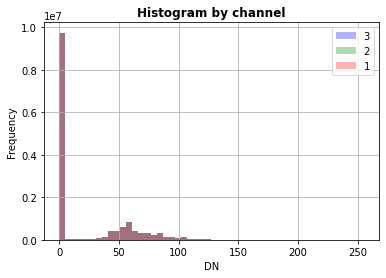

In [23]:
show_hist(
     src.read(), bins=50, lw=0.0, stacked=False, alpha=0.3,
     histtype='stepfilled', title="Histogram by channel")

For the red channel, the histogram shows two clusters of values, below which the data is mostly noise, and above which the signal is clearer.

### Preprocess raster

Before we can extract meaninful information from the raster image, we need to clean up noise in the image and make the signal clearer. Based on the histogram above, we could suggest a threshold in the red channel of 100 to mask the data and remove the noise.

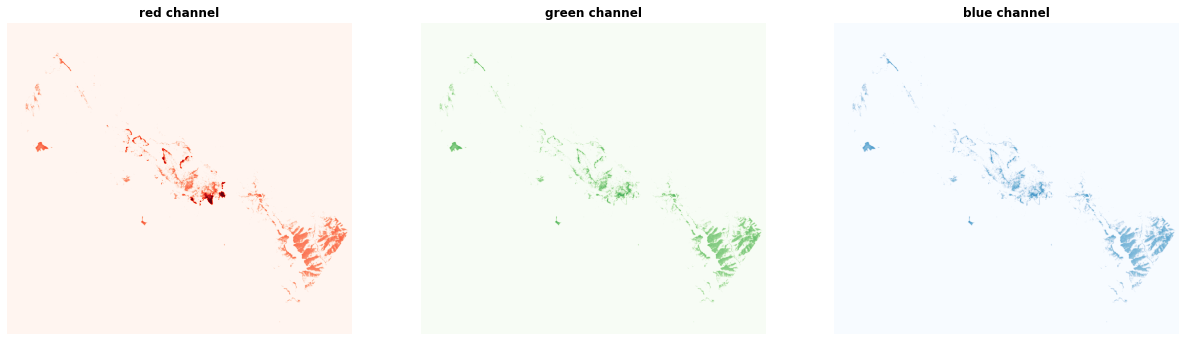

In [24]:
threshold = 100

r[r < threshold] = 0
g[g < threshold] = 0
b[b < threshold] = 0

fig, (axr, axg, axb) = plt.subplots(1,3, figsize=(21,7))
show(r, ax=axr, cmap='Reds', title='red channel')
show(g, ax=axg, cmap='Greens', title='green channel')
show(b, ax=axb, cmap='Blues', title='blue channel')

for ax in (axr, axg, axb):
    ax.set_axis_off()

plt.show()

A number of further cleansing operations have been applied below. You can experiment with different strategies including machine learning and feature engineering to find an optimal process.

The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?


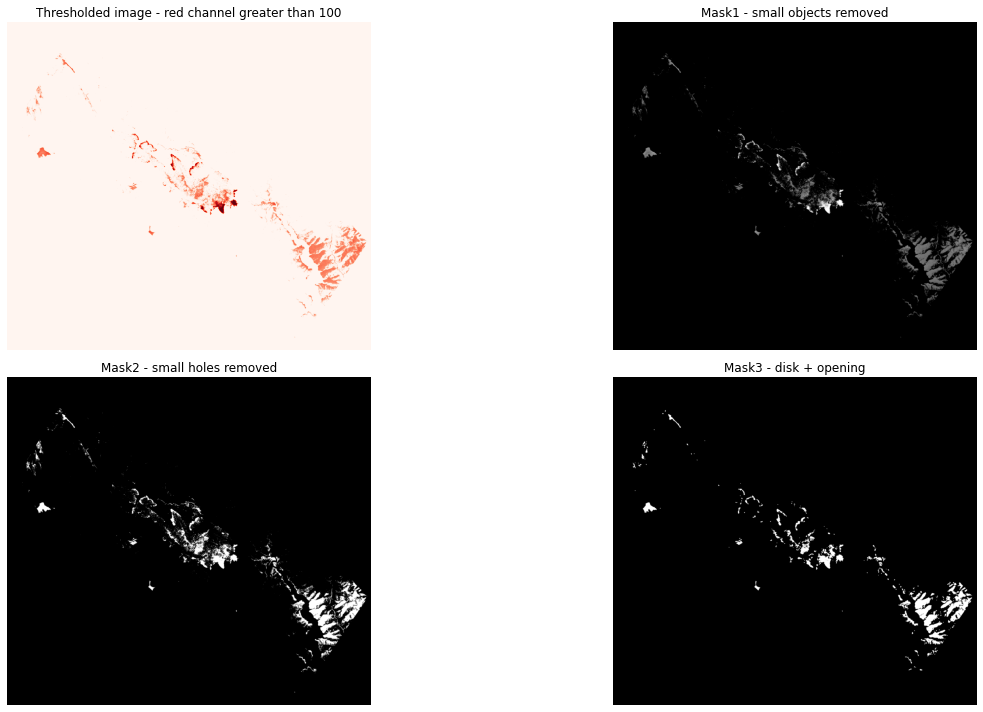

In [25]:
r = src.read(1)
threshold = 100
r[r < threshold] = 0

lum = color.rgb2gray(r)
mask1 = morphology.remove_small_objects(lum, 50)
mask2 = morphology.remove_small_holes(mask1, 5)
mask3 = morphology.opening(mask2, morphology.disk(3))

fig, ax_arr = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(20, 10))
ax1, ax2, ax3, ax4 = ax_arr.ravel()

ax1.imshow(r, cmap='Reds')
ax1.set_title("Thresholded image - red channel greater than " + str(threshold))

ax2.imshow(mask1, cmap="gray")
ax2.set_title("Mask1 - small objects removed")

ax3.imshow(mask2, cmap="gray")
ax3.set_title("Mask2 - small holes removed")

ax4.imshow(mask3, cmap="gray")
ax4.set_title("Mask3 - disk + opening")

for ax in ax_arr.ravel():
    ax.set_axis_off()

plt.tight_layout()
plt.show()

At this point, our mask is just a table of values, it is not georeferenced.  We can write this array into a temporary rasterio dataset so that we can query it in context with the source linescan image.

In [37]:
# convert boolean mask to integers
mask = mask3.astype(np.uint8)

# create a temporary dataset for storing the array
temp = rasterio.open(
    'tmp.tif',
    mode='w+',
    driver='GTiff',
    height=mask.shape[0],
    width=mask.shape[1],
    count=1,
    dtype=mask.dtype,
    crs=src.crs,
    transform=src.transform)

# copy the array into the opened dataset
temp.write(mask, 1)

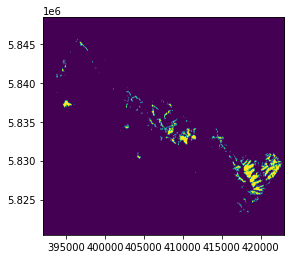

In [38]:
show(temp.read(), transform=src.transform)

In [39]:
temp.close()

Now, the mask is georeferenced. To understand more about the rasterio.open() function, uncomment and run the cell below.

In [17]:
# help(rasterio.open)

Once we are happy with our preprocessing steps, we can create a function to pass each image to directly.

In [40]:
def get_mask(img, thresh):
    r = img.read(1)
    r[r < thresh] = 0
    lum = color.rgb2gray(r)
    mask1 = morphology.remove_small_objects(lum, 50)
    mask2 = morphology.remove_small_holes(mask1, 5)
    mask3 = morphology.opening(mask2, morphology.disk(3))
    mask3[mask3 > 0 ] = 255
    return mask3.astype(np.uint8)

The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?


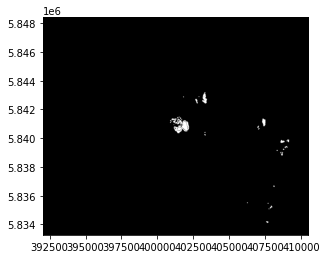

In [41]:
mask = get_mask(src, 90)
show(mask, transform=src.transform, cmap='binary_r')

### Making a submission
For the five linescans where there is no mask provided, you must first create a mask, and then return True or False for a specific set of coordinates, where True indicates that coordinate is on fire, and False indicates it is not.

The "test.csv" file provides a list of 1000 coordinates that are required to be classified for each of these five linescans. For this part of the challenge, you can ignore the dateTimeLocal column as we are not working with timestamps yet. Note that the coordinates are denoted in the CRS mentioned above, epsg:28355.

In [42]:
test = pd.read_csv('test.csv', index_col='id')
test.head()

,stem,x,y,dateTimeLocal,target
id,,,,,
0,YARRA51 575 P1_201903040506_MGA94_55,393711,5837298,4/03/2019 5:06,NaN
1,YARRA51 575 P1_201903040506_MGA94_55,400735,5834457,4/03/2019 5:06,NaN
2,YARRA51 575 P1_201903040506_MGA94_55,390805,5843457,4/03/2019 5:06,NaN
3,YARRA51 575 P1_201903040506_MGA94_55,400285,5833340,4/03/2019 5:06,NaN
4,YARRA51 575 P1_201903040506_MGA94_55,390229,5837975,4/03/2019 5:06,NaN


The index method allows you to pass in a set of x and y coordinates and return the row and column of a rasterio dataset which is georeferenced in space. We can then index the dataset using this row and col to return the value at that address.

In [43]:
# get the red band of the dataset only
red = src.read(1)

# get the coordinates of the centre of the dataset
x, y = (src.bounds.left + src.width // 2 , src.bounds.top - src.height // 2)

# get the row and column indicies that correspond to the centre of the dataset
row, col = src.index(x, y)

# get the value at that address
red[row, col]

0

Now we will iterate over the test set of linescan images, and iterate over the test coordinates required in each image, filling the 'onFire' column of the 'test' dataframe with the results of the masking process we have developed.

In [44]:
fnames = test.stem.unique()
fnames

array(['YARRA51 575 P1_201903040506_MGA94_55',
       'YARRA51 515 P1_201903021645_MGA94_55',
       'YARRA51 529 P1_201903021935_MGA94_55',
       'YARRA51 633 P1_201903061644_MGA94_55',
       'WALHALLA 354 P1_201902031637_MGA94_55'], dtype=object)

In [48]:
for file_stem in fnames:
    
    # open the raster file and georeference with the corresponding world file
    raster_filename = 'input_linescan/' + file_stem + '.jpg'
    world_filename = 'world/'  + file_stem + '.bqw'
    src = rasterio.open(raster_filename, mode='r+')
    a, d, b, e, c, f = np.loadtxt(world_filename)    # order depends on convention
    transform = Affine(a, b, c, d, e, f)
    crs = rasterio.crs.CRS({"init": "epsg:28355"})     # "epsg:4326"  WGS 84,  or whatever CRS you know the image is in
    src.transform = transform
    src.crs = crs
    
    # create a mask using the process we developed earlier. For this example, provide the same threshold for all linescans
    mask = get_mask(src, 100)

    # create a temporary dataset for storing the array
    temp = rasterio.open(
        'tmp.tif',
        mode='w+',
        driver='GTiff',
        height=mask.shape[0],
        width=mask.shape[1],
        count=1,
        dtype=mask.dtype,
        crs=src.crs,
        transform=src.transform)

    # copy the array into the opened dataset
    temp.write(mask, 1)

    # iterate over the coordinates that are required for testing in the current linescan file
    for idx, ob in test.loc[test.stem==file_stem].iterrows():
        row, col = temp.index(ob.x, ob.y)
        result = temp.read(1)[row, col]
        test.loc[(test.stem==file_stem) & (test.x==ob.x) & (test.y==ob.y), 'target'] = result
    
    temp.close()

The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?


In [49]:
test.to_csv('sample_submission.csv', columns = ['target'])
test.head()

,stem,x,y,dateTimeLocal,target
id,,,,,
0,YARRA51 575 P1_201903040506_MGA94_55,393711,5837298,4/03/2019 5:06,0.0
1,YARRA51 575 P1_201903040506_MGA94_55,400735,5834457,4/03/2019 5:06,0.0
2,YARRA51 575 P1_201903040506_MGA94_55,390805,5843457,4/03/2019 5:06,0.0
3,YARRA51 575 P1_201903040506_MGA94_55,400285,5833340,4/03/2019 5:06,0.0
4,YARRA51 575 P1_201903040506_MGA94_55,390229,5837975,4/03/2019 5:06,0.0


Submit your file to the EY Data Science platform for grading.

***
## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question in the [Troubleshooting EY Data Science Program MS Teams Channel](https://teams.microsoft.com/l/channel/19%3a90804a73cb5a4159a60693c41a8820d2%40thread.tacv2/Troubleshooting?groupId=f6acd945-fed9-4db4-bed8-414988473a36&tenantId=5b973f99-77df-4beb-b27d-aa0c70b8482c) or on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** October 2020